In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%load_ext rpy2.ipython

In [ ]:
# Do not interpolate blinks, leave as nan
# Label baselines that are blinks or artifacts, leave as nan
# Regress out the effect of x_pos and y_pos over the entire run
# Then do linear interpolation (or cubic)
# Look through time series to find subjects time series that look weird. Reject participants. 
# Divide by trial and return. 
# Determine if there are any differences in pupil size between the two conditions.
# Based on gain, loss and dist_indiff and a time series term. 

##### Data

In [2]:
# Import and process data
pupil_df = pd.read_csv("./data/behavior_pupil.csv")

# Remove trials that are the start of a run, have no response, or have a reaction time less than 0.1
pupil_df = pupil_df.query("is_start_of_run != 1 & response_int.notna() & rt > 0.1")
# Remove the time column for just behavior analysis
behavior_df = pupil_df.groupby(['subj_ID', 'condition', 'trial', 'run', 'gain', 'loss'])[["accept", "uncertainty", "rt", 
                                                                                          "response_int", 'numblinks_during_trial',
                                                                                          'numblinks_after_trial', 'numartifacts_during_trial', 
                                                                                          'numartifacts_after_trial']].mean().reset_index()

In [3]:
pupil_resp_df = pd.read_csv("./data/behavior_pupil_resp_aligned.csv")

In [4]:
# Make a new column called condition_num where it is 0 if condition is equalRange
behavior_df['condition_num'] = behavior_df['condition'].apply(lambda x: 0 if x == 'equalRange' else 1)
pupil_df['condition_num'] = pupil_df['condition'].apply(lambda x: 0 if x == 'equalRange' else 1)

In [5]:
# make a new column called dist from center, where it is equal to the distance from (x_pos, y_pos) to (1920 // 2, 1080 // 2)
pupil_df['dist_from_center'] = np.sqrt((pupil_df['x_pos'] - 1920 // 2) ** 2 + (pupil_df['y_pos'] - 1080 // 2) ** 2)

In [6]:
# Compute baseline for each trial as the average pupil size in the 500ms before the trial
baseline = pupil_df.query("time < 0").groupby(['subj_ID', 'trial'])['pupil_size'].mean().reset_index()

# Substract from pupil for each trial/subject
pupil_df = pupil_df.merge(baseline, on=['subj_ID', 'trial'], suffixes=('', '_baseline'))

In [7]:
mean_run_pupil = pupil_df.groupby(['subj_ID', 'run'])['pupil_size'].mean().reset_index()
pupil_df = pupil_df.merge(mean_run_pupil, on=['subj_ID', 'run'], suffixes=('', '_mean'))

In [8]:
pupil_df["pupil_size_demeaned"] = pupil_df["pupil_size"] - pupil_df["pupil_size_mean"]

In [9]:
pupil_df['pupil_size_norm'] = (pupil_df['pupil_size'] - pupil_df['pupil_size_baseline']) 

In [10]:
# create a new column pupil_baseline_mean that is equal to the mean 
subj_run_baseline = pupil_df.groupby(['subj_ID', 'run'])['pupil_size_baseline'].mean().reset_index()

# Merge the baseline mean back into the pupil_df
pupil_df = pupil_df.merge(subj_run_baseline, on=['subj_ID', 'run'], suffixes=('', '_run_baseline'))

In [11]:
pupil_df['pupil_size_norm2'] = (pupil_df['pupil_size'] - pupil_df['pupil_size_baseline_run_baseline']) / pupil_df['pupil_size_baseline_run_baseline']

In [12]:
r_pupil_df = pupil_df[['subj_ID', 'time', 'condition_num', 'trial', 'run', 'gain', 'loss', 'x_pos',
                       'y_pos', 'pupil_size_norm', 'dist_indiff', 'response_int', 'accept', 'uncertainty',
                       'pupil_size_baseline', 'pupil_size', 'pupil_size_norm2', 'pupil_size_demeaned', 'pupil_size_mean']]

To do in the data processing repository:
* Change the names of the columns
* Create a df with summary statistics of the trial and another one with the pupil size timecourse per trial. 
* Include the first derivative of the pupil size (helpful for future)
* Determine if artifact removal is really necessary (instead of perhaps just smoothing)


#### Pupil models in R

In [13]:
%%R -i r_pupil_df
# install.packages("mgcv")
library(mgcv)

Loading required package: nlme
This is mgcv 1.9-1. For overview type 'help("mgcv-package")'.


In [14]:
%%R
# smooth term for x_pos, y_pos by subj_ID and run
m0 <- bam(pupil_size_demeaned ~  s(x_pos, y_pos, by=interaction(subj_ID)),
        data=r_pupil_df,
        method = "fREML", 
        discrete = TRUE)

In [15]:
%%R
# regress out the m0 from pupil_size_demeaned
r_pupil_df$pupil_size_demeaned_resid <- residuals(m0)


In [17]:
%%R
# install.packages("dplyr") # Install if not already installed
library(dplyr)            # Load the package
# Add pupil size mean to the residuals to compute the adjusted pupil size
r_pupil_df$pupil_size_demeaned_resid_plus_mean <- 
  r_pupil_df$pupil_size_demeaned_resid + r_pupil_df$pupil_size_mean

# Compute baseline for each trial as the average pupil size in the 500ms before the trial
baseline <- r_pupil_df %>%
  filter(time < 0) %>%
  group_by(subj_ID, trial) %>%
  summarise(pupil_size_demeaned_resid_plus_mean_baseline = mean(pupil_size_demeaned_resid_plus_mean, na.rm = TRUE)) %>%
  ungroup()

# Merge the baseline back into the original dataframe
r_pupil_df <- r_pupil_df %>%
  left_join(baseline, by = c("subj_ID", "trial"))

# Compute the normalized pupil size
r_pupil_df$pupil_size_norm3 <- 
  (r_pupil_df$pupil_size_demeaned_resid_plus_mean - 
     r_pupil_df$pupil_size_demeaned_resid_plus_mean_baseline) / 
  r_pupil_df$pupil_size_demeaned_resid_plus_mean_baseline

`summarise()` has grouped output by 'subj_ID'. You can override using the
`.groups` argument.



Attaching package: ‘dplyr’

The following object is masked from ‘package:nlme’:

    collapse

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [36]:
%%R
# smooth term for x_pos, y_pos by subj_ID and run
m1 <- bam(pupil_size_norm3 ~  s(time) + s(time, by=gain) + s(time, by=loss) + s(time, by=dist_indiff) + s(time, by=interaction(response_int)),
        random = list(subj_ID = ~1),
        data=r_pupil_df,
        method = "fREML", 
        discrete = TRUE)

In [55]:
%R -o r_pupil_df

In [98]:
r_pupil_df['pupil_size_demeaned_resid_plus_mean'] = r_pupil_df['pupil_size_demeaned_resid'] + r_pupil_df['pupil_size_mean']

#Compute baseline for each trial as the average pupil size in the 500ms before the trial
baseline = r_pupil_df.query("time < 0").groupby(['subj_ID', 'trial'])['pupil_size_demeaned_resid_plus_mean'].mean().reset_index()

# Substract from pupil for each trial/subject
r_pupil_df = r_pupil_df.merge(baseline, on=['subj_ID', 'trial'], suffixes=('', '_baseline'))

r_pupil_df['pupil_size_norm3'] = (r_pupil_df['pupil_size_demeaned_resid_plus_mean'] - r_pupil_df['pupil_size_demeaned_resid_plus_mean_baseline']) / r_pupil_df['pupil_size_demeaned_resid_plus_mean_baseline']

In [57]:
r_pupil_df

,subj_ID,time,condition_num,trial,run,gain,loss,x_pos,y_pos,pupil_size_norm,...,uncertainty,pupil_size_baseline,pupil_size,pupil_size_norm2,pupil_size_demeaned,pupil_size_mean,pupil_size_demeaned_resid,pupil_size_demeaned_resid_plus_mean,pupil_size_demeaned_resid_plus_mean_baseline,pupil_size_norm3
1,3,-0.5,1,2,1,38,14,1035.370000,644.820000,-14.902610,...,0,6420.263892,6405.361282,0.141769,667.033118,5738.328164,456.474393,6194.802557,6227.982759,-0.005328
2,3,-0.5,1,3,1,10,18,979.188720,890.142378,-73.752615,...,1,5613.310439,5539.557824,-0.012563,-198.770340,5738.328164,-146.386791,5591.941373,5544.363450,0.008581
3,3,-0.5,1,4,1,16,5,1018.420000,814.980000,-4.659721,...,0,6338.965482,6334.305760,0.129103,595.977596,5738.328164,504.006980,6242.335144,6213.604277,0.004624
4,3,-0.5,1,5,1,40,12,991.520000,568.550000,88.307265,...,0,5485.189725,5573.496990,-0.006513,-164.831174,5738.328164,-289.222285,5449.105879,5426.620837,0.004143
5,3,-0.5,1,6,1,40,18,960.110000,546.640000,334.609921,...,0,5625.772940,5960.382861,0.062450,222.054697,5738.328164,163.030361,5901.358526,5507.838839,0.071447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862221,124,4.0,0,252,4,7,14,970.513926,472.905201,-718.021209,...,0,5859.853983,5141.832774,-0.111179,-689.418186,5831.250960,-689.325128,5141.925832,5815.357396,-0.115802
862222,124,4.0,0,253,4,5,9,951.070000,398.470000,-315.877061,...,0,5839.645761,5523.768699,-0.045158,-307.482261,5831.250960,-243.829751,5587.421209,5935.222392,-0.058600
862223,124,4.0,0,254,4,5,15,853.740000,468.310000,502.848164,...,0,5989.413259,6492.261423,0.122257,661.010463,5831.250960,559.018002,6390.268962,5919.752453,0.079482
862224,124,4.0,0,255,4,12,18,1059.640000,528.410000,279.316974,...,0,5449.881913,5729.198888,-0.009647,-102.052072,5831.250960,-80.187918,5751.063042,5439.969061,0.057187


<Axes: xlabel='time', ylabel='pupil_size_norm3'>

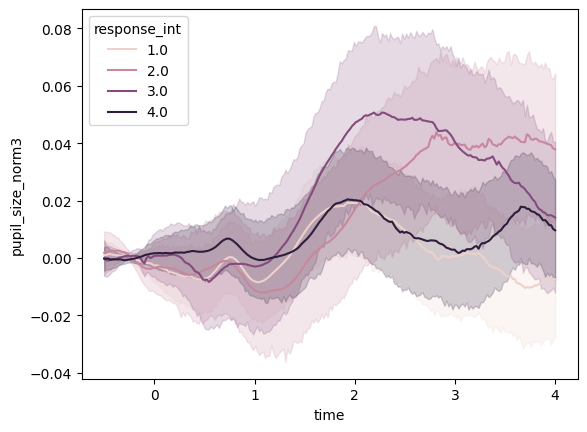

In [59]:
sns.lineplot(r_pupil_df.query("subj_ID == 4"), x = 'time', y = 'pupil_size_norm3', hue = 'response_int')

<Axes: xlabel='time', ylabel='pupil_size_norm3'>

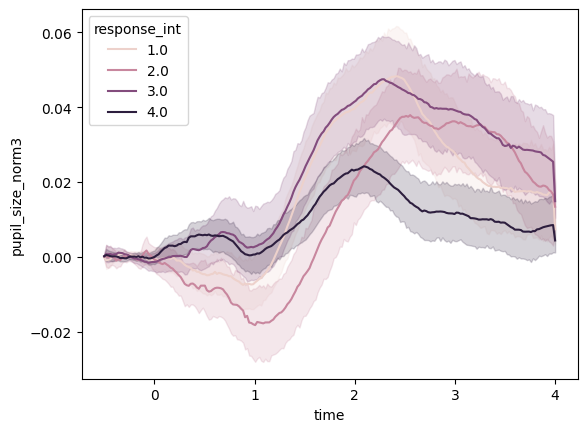

In [110]:
sns.lineplot(r_pupil_df.query("condition_num == 1"), x = 'time', y = 'pupil_size_norm3', hue = 'response_int')

In [69]:
%%R
m0 <- bam(pupil_size ~ pupil_size_baseline + response_int * condition + s(time, by=interaction(response_int, condition), k=20) + s(x_pos, y_pos, by=subj_ID, k = 100),
        random = list(subj_ID = ~1),
        data=pupil_df,
        method = "fREML", 
        discrete=TRUE)

In [50]:
%%R
rho2 <-round( acf(resid(m0), plot=FALSE)$acf[2],2)

In [63]:
%%R
m0rho <- bam(pupil_size ~ pupil_size_baseline + response_int * condition + s(time, by=interaction(response_int, condition), k=20) + s(x_pos, y_pos, k=100)
             , random = list(subj_ID = ~1),
            data=pupil_df,
            method = "fREML", 
            discrete=TRUE, rho=rho2)

In [37]:
%%R
summary(m1)


Family: gaussian 
Link function: identity 

Formula:
pupil_size_norm3 ~ s(time) + s(time, by = gain) + s(time, by = loss) + 
    s(time, by = dist_indiff) + s(time, by = interaction(response_int))

Parametric coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.0112269  0.0003468   32.37   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                                     edf Ref.df       F p-value    
s(time)                            6.293  7.063  20.112 < 2e-16 ***
s(time):gain                       9.097  9.533  24.181 < 2e-16 ***
s(time):loss                       7.130  8.088 248.475 < 2e-16 ***
s(time):dist_indiff                8.262  9.130  46.352 < 2e-16 ***
s(time):interaction(response_int)1 7.880  8.531  14.320 < 2e-16 ***
s(time):interaction(response_int)2 6.732  7.732   7.938 < 2e-16 ***
s(time):interaction(response_int)3 1.291  1.358   7.613 0.00277 ** 
s(time):intera


Method: fREML   Optimizer: perf chol
$grad
[1]  3.365541e-08  1.187135e-10  2.334969e-08  2.755991e-10 -7.817289e-08

$hess
         [,1]        [,2]        [,3]        [,4]          [,5]
   2.28972570 -0.12504417  0.06484237  0.01127888     -2.930629
  -0.12504417  2.48332812 -0.01863086 -0.63807494     -3.437048
   0.06484237 -0.01863086  3.02803981  0.07060499     -3.480492
   0.01127888 -0.63807494  0.07060499  2.81617484     -2.916674
d -2.93062880 -3.43704774 -3.48049212 -2.91667391 431108.500000

Model rank =  40 / 40 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                       k'   edf k-index p-value
s(time)              9.00  6.86    0.99    0.23
s(time):gain        10.00  8.87    0.99    0.19
s(time):loss        10.00  8.96    0.99    0.20
s(time):dist_indiff 10.00  7.83    0.99    0.15


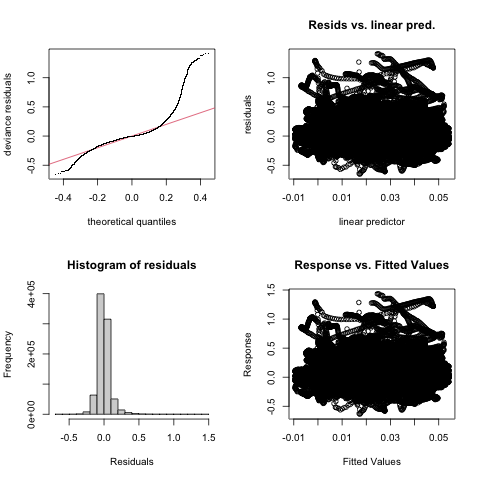

In [33]:
%%R
gam.check(m1)

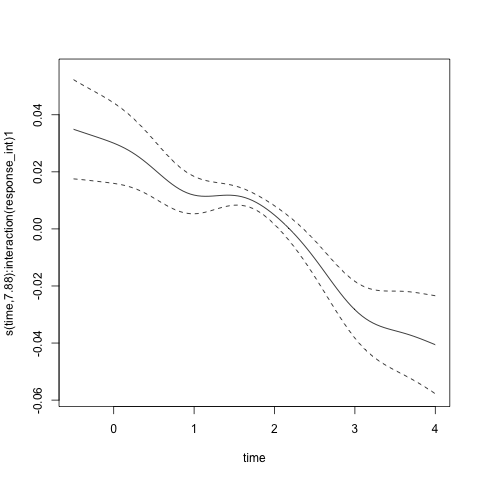

In [51]:
%%R
plot(m1, select=5,scheme=2)

Summary:
	* pupil_size_baseline : numeric predictor; set to the value(s): 5558.85266336366. 
	* time : numeric predictor; with 30 values ranging from -0.500000 to 4.000000. 
	* condition_num : numeric predictor; set to the value(s): 0, 1. 
	* x_pos : numeric predictor; set to the value(s): 988.284126984114. 
	* y_pos : numeric predictor; set to the value(s): 559.35. 
	* NOTE : No random effects in the model to cancel.
 


In addition: Warning message:
In plot_smooth(m0, view = "time", plot_all = "condition_num", rm.ranef = TRUE,  :
  Predictor condition_num is not a factor.


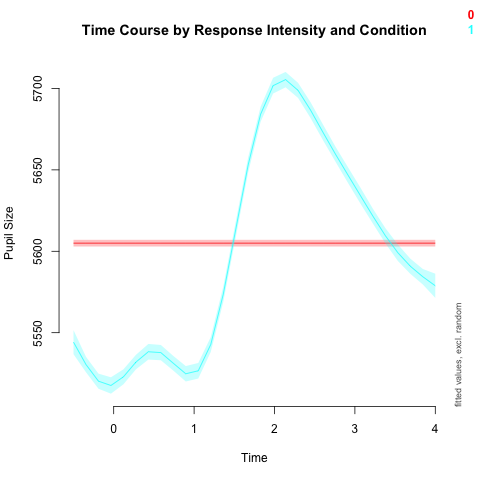

In [78]:
%%R
library(plotfunctions)
library(itsadug)
plot_smooth(m0, view = "time", 
            plot_all = "condition_num", 
            rm.ranef = TRUE, 
            main = "Time Course by Response Intensity and Condition",
            xlab = "Time", 
            ylab = "Pupil Size")

In [39]:
%%R
library(plotfunctions)
library(itsadug)
plot_smooth(m1, view = "time", 
            plot_all = "response_int", 
            rm.ranef = TRUE, 
            main = "Time Course by Response Intensity and Condition",
            xlab = "Time", 
            ylab = "Pupil Size")

Error in `[.data.frame`(x$model, , i) : undefined columns selected


RInterpreterError: Failed to parse and evaluate line 'library(plotfunctions)\nlibrary(itsadug)\nplot_smooth(m1, view = "time", \n            plot_all = "response_int", \n            rm.ranef = TRUE, \n            main = "Time Course by Response Intensity and Condition",\n            xlab = "Time", \n            ylab = "Pupil Size")\n'.
R error message: 'Error in `[.data.frame`(x$model, , i) : undefined columns selected'

In [ ]:
%%R
gamm_model <- bam(pupil_size ~ s(time, by = trial) + s(subj_ID, bs = "re"),
                  data = pupil_df, 
                  family = gaussian())

In [7]:
%%R
summary(gamm_model)


Family: gaussian 
Link function: identity 

Formula:
pupil_size ~ s(time, by = trial) + s(subj_ID, bs = "re")

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.318121   0.009184   34.64   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                 edf Ref.df    F p-value    
s(time):trial 9.9754     10 7571  <2e-16 ***
s(subj_ID)    0.9995      1 2195  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.0245   Deviance explained = 2.45%
fREML = 9.9515e+06  Scale est. = 36.125    n = 3097800


Error in `geom_line()`:
! Problem while computing aesthetics.
ℹ Error occurred in the 2nd layer.
Caused by error:
! object 'predicted_pupil' not found
Run `rlang::last_trace()` to see where the error occurred.


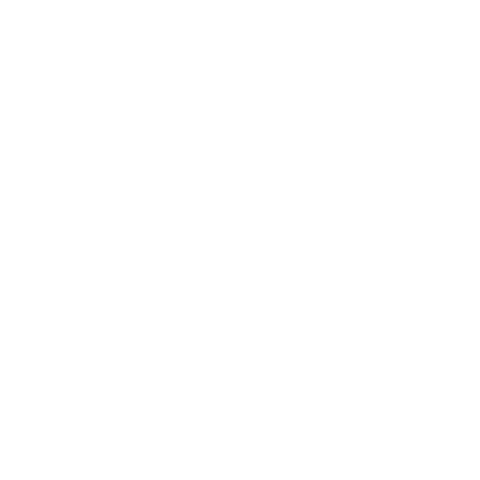

RRuntimeError: Error in geom_line(aes(y = predicted_pupil), linetype = "dashed") : 
ℹ Error occurred in the 2nd layer.
Caused by error:
! object 'predicted_pupil' not found


In [10]:
%%R
library(ggplot2)
ggplot(pupil_df, aes(x = time, y = pupil_size, color = factor(trial))) +
  geom_point() +
  geom_line(aes(y = predicted_pupil), linetype = "dashed") +
  facet_wrap(~ subj_ID) +
  theme_minimal()

##### Pupil models

1. How does accepting affect pupil size?
 - Behavior or sensory impact pupil size across time bins?

In [22]:
formulas = {"formula1" : "pupil_size ~ gain + loss + gain:loss",}
formulas = {"formula1" : "pupil_size_norm2 ~ gain + loss + dist_indiff + gain:condition_num + loss:condition_num + dist_indiff:condition_num",}
formulas = {"formula1" : "pupil_size ~ gain + loss",}

# formulas = {"formula1" : "pupil_size ~ accept + uncertainty + accept:condition_num + uncertainty:condition_num",}


In [25]:
formulas_results = dict()
formulas_model_fit = dict()
for formula_name, formula in formulas.items():
    prev_coefs = dict()
    results = {'time' : [], 'variable' : [], 'coef' : [], 'style' : [], 'p_values' : []}
    model_fit = {'time' : [], 'mean_residuals' : [], 'std_residuals' : [], "llf" : []}

    delta_time = 0.25
    total_trial_time = 2
    t_start = -1
    t_end = t_start + delta_time

    while t_start < total_trial_time:
        print(f"t_start: {t_start}, t_end: {t_end}")
        temp_df = pupil_df.query(f"time >= {t_start} & time < {t_end} & subj_ID == 3").groupby(['subj_ID', 'condition_num', 'gain', 'loss'])[['pupil_size']].mean().reset_index()
        # temp_df = pupil_df.query(f"time >= {t_start} & time < {t_end} & subj_ID == 3").groupby(['subj_ID', 'condition_num', 'gain', 'loss', 'dist_indiff'])[['pupil_size_norm2', 'pupil_size_baseline', 'accept', 'uncertainty', 'dist_from_center']].mean().reset_index()
        # model = smf.mixedlm(formula=formula, data=temp_df, groups=temp_df["subj_ID"]).fit()
        model = smf.glm(formula=formula, data=temp_df, family=sm.families.Gaussian()).fit()
        t = (t_start + t_end) / 2
        for name, value in model.params.items():
            results['time'].append(t)
            results['variable'].append(name)
            results['coef'].append(value)
            results['style'].append('sig' if model.pvalues[name] < 0.005 else 'non-sig')
            results['p_values'].append(model.pvalues[name])
            # prev_coefs[name] = value
            # prev_coefs[f'{name}_style'] = 'sig' if model.pvalues[name] < 0.005 else 'non-sig'

        model_fit['time'].append(t)
        # model_fit['mean_residuals'].append(model.resid.mean())
        # model_fit['std_residuals'].append(model.resid.std())
        model_fit['llf'].append(model.llf)
        
        t_start = t_end
        t_end = t_start + delta_time
    
    formulas_results[formula_name] = pd.DataFrame(results)
    # formulas_model_fit[formula_name] = pd.DataFrame(model_fit)

t_start: -1, t_end: -0.75
t_start: -0.75, t_end: -0.5
t_start: -0.5, t_end: -0.25
t_start: -0.25, t_end: 0.0
t_start: 0.0, t_end: 0.25
t_start: 0.25, t_end: 0.5
t_start: 0.5, t_end: 0.75
t_start: 0.75, t_end: 1.0
t_start: 1.0, t_end: 1.25
t_start: 1.25, t_end: 1.5
t_start: 1.5, t_end: 1.75
t_start: 1.75, t_end: 2.0


/var/folders/xd/6fbjp5ms7ss8c4xxlmz91xkm0000gn/T/ipykernel_71657/1163443415.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


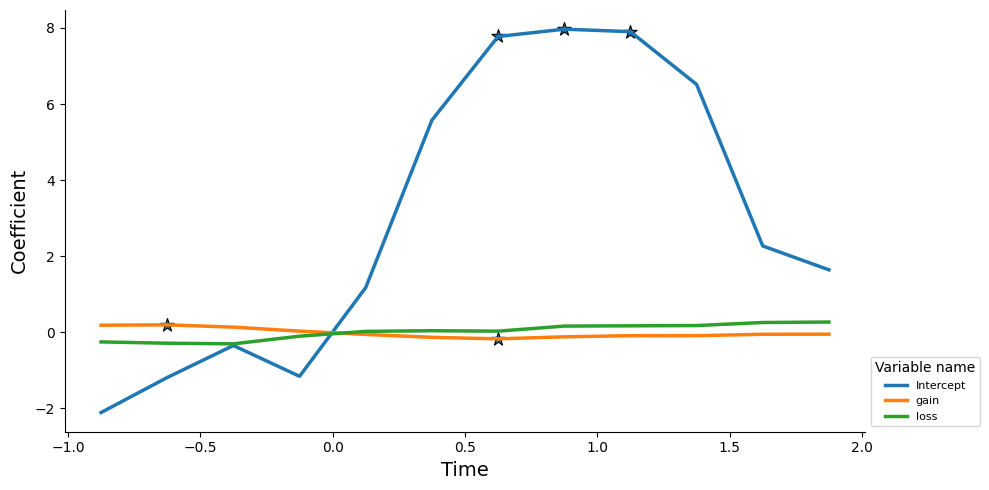

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))

# Line plot for coefficients through time
sns.lineplot(
    data=formulas_results["formula1"], 
    x="time", 
    y="coef", 
    hue="variable", 
    linewidth=2.5,  # Thicker lines for better visibility
    ax=ax
)

# Scatter plot to highlight significance
sns.scatterplot(
    data=formulas_results["formula1"].query("style == 'sig'"), 
    x="time", 
    y="coef", 
    s=100,  # Bigger dots
    marker='*',  # Circle markers
    edgecolor='black',  # Black edge for better contrast
    palette={"sig": "red"},  # Custom colors
    ax=ax
)

# Customize the title and labels
# ax.set_title("Coefficients Through Time", fontsize=18, fontweight='bold')
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Coefficient", fontsize=14)

# Adjust the legend
# Place it outside the plot
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles[:len(set(formulas_results["formula1"]['variable']))], 
    labels=labels[:len(set(formulas_results["formula1"]['variable']))], 
    title="Variable", 
    loc='upper left', 
    bbox_to_anchor=(1, 1), 
    fontsize=12
)

# Add legend for "style" below the plot
ax.legend(
    handles=handles[len(set(formulas_results["formula1"]['variable'])):], 
    labels=labels[len(set(formulas_results["formula1"]['variable'])):], 
    title="Variable name", 
    loc='lower left', 
    bbox_to_anchor=(1, 0), 
    fontsize=8
)

# Final adjustments
sns.despine()  # Removes top and right spines
plt.tight_layout()  # Adjust layout to fit everything nicely

# plt.ylim(-20, 20)
plt.show()



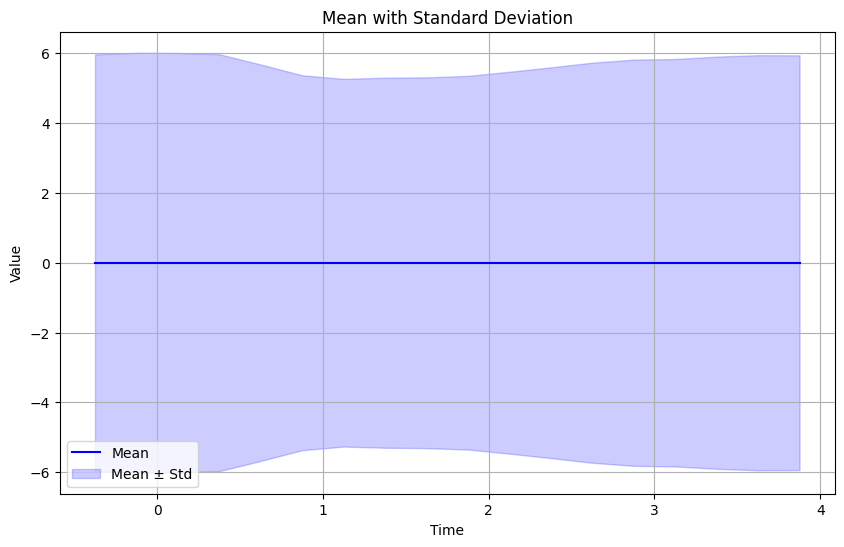

In [166]:
# Plot the mean and standard deviation
plt.figure(figsize=(10, 6))
plt.plot(formulas_model_fit['formula1']['time'], formulas_model_fit['formula1']['mean_residuals'], label='Mean', color='blue')
plt.fill_between(
    formulas_model_fit['formula1']['time'], 
    formulas_model_fit['formula1']['mean_residuals'] - formulas_model_fit['formula1']['std_residuals'], 
    formulas_model_fit['formula1']['mean_residuals'] + formulas_model_fit['formula1']['std_residuals'], 
    color='blue', 
    alpha=0.2, 
    label='Mean ± Std'
)

# Add labels, legend, and grid
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Mean with Standard Deviation')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
%%R -o pupil_df
gaze_model <- gam(pupil_size ~ s(x_pos, y_pos, by=subj_ID, k = 100), data = pupil_df)
pupil_df$pupil_size_adjusted <- residuals(gaze_model)

# sns.lineplot(data=pupil_df.query("subj_ID == 4"), x='time', y='pupil_size_adjusted', hue = 'uncertainty')